# Dostoevsky GPT

Fyodor Mikhailovich Dostoevsky (1821 - 1881) is a Russian author and novelist, and is arguably one of the greatest novelists in the history of literature. Notably, towards the end of his life, Dostoevsky was in the process of writing a novel titled Nietoshka Nezvanova. However, unfortunately, he passed away before he is able to finish the book.

Therefore, for fun of course, I will build my own Transformer GPT model (that is, a decoder-only transformer with character-wise tokenization) inside this notebook that will learn off of all of what is written on the unfinished novel Nietoshka Nezvanova and then generate future text. This future text is what the model thinks should be how the story continues (even though, of course, this is probably not what Dostoevsky himself would have wrote had he finished the book...). Thus, essentially, in the end we can generate and infer our own fully-finished versions of Nietoshka Nezvanova!

Note that, due to computation limitations and the fact that I am not willing to spend months training an LLM, the transformer model is rather small. Thus, the generation texts will not be as accurate or sensible compared to a more sophisticated GPT.

Here are some things a curious learner with an absolute beast of a NVIDIA GPU can do to (but not limited to) make this model better:
1. Enlarge the model by increasing hyperparameters such as
    - number of attention heads,
    - number of unfolding layers,
    - max number of tokens the model can process at once
    - more training epochs,
    - etc.
2. Use a more robust tokenization technique such as Byte-Pair Encoding (BPE), WordPiece, etc.
3. First pre-train the transformer on some of Dostoevsky's other works to learn more about his writing style and any linguistic/contextual complexities
   to better adapt the model to his writings. Afterwards, fine-tune the model specifically on Nietoshka Nezvanova to have the model generate text  specific to that novel
   - In fact, a text file of The Brothers Karamazov, Dostoevsky's longest work, is attached under /data for you to try and pre-train.

Credits:
- The text file for Netochka Nezvanova is directly taken from: https://www.thetedkarchive.com/library/fyodor-dostoevsky-netochka-nezvanova-an-incomplete-novel
- The text file for The Brothers Karamazov is directly taken from: https://www.gutenberg.org/ebooks/28054

## 0. Imports, Hyperparameters, Data Retrieval

In [1]:
# Necessary imports
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from torch.nn import functional as F

# Since I am using Google Colab (for CUDA support), I need to first mount drive for file imports
from google.colab import drive
drive.mount('/content/drive')

# Setting torch manual seed
torch.manual_seed(42)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
LEARNING_RATE = 3e-4
EPOCHS = 10 # Make this value greater for more accurate results
NUM_GENERATE = int(1e4) # Make this value greater for more text
PLOT_STEPS = 1
PRINT_STEPS = 1
DROPOUT = 0.20
BATCH_SIZE = 64
BLOCK_SIZE = 128 # Make this value greater for more accurate results
N_EMBED = 264 # Make this value greater for more accurate results
N_HEAD = 6 # Make this value greater for more accurate results
N_LAYERS = 4 # Make this value greater for more accurate results
WEIGHT_DECAY = 1e-4

torch.__version__, device

Mounted at /content/drive


('2.5.1+cu121', 'cuda')

In [2]:
# Get text data
with open('/content/drive/My Drive/netochka-nezvanova.txt', 'r', encoding='utf-8') as f:
  content = f.read()

# Get all unique characters from both texts
vocab = sorted(list(set(content)))
vocab_size = len(vocab)

print(f"Vocab: {vocab}")
print(f"Vocab Size: {vocab_size}")

Vocab: ['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '0', '2', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'é', 'ê', '—', '‘', '’', '“', '”']
Vocab Size: 74


## 1. Data Processing

In [3]:
# Create bidirectional mappings from characters to indices
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}

# Create encoding and decoding functions
def encode(s: str) -> list[int]:
  return [stoi[c] for c in s]

def decode(l: list[int]) -> str:
  return ''.join([itos[i] for i in l])

# Test random examples to ensure everything works
print(encode("Raskolnikov"))
print(decode(encode("Ivanovna")))

[32, 40, 58, 50, 54, 51, 53, 48, 50, 54, 61]
Ivanovna


In [4]:
# Get data and convert to tensor
data = torch.tensor(encode(content), dtype=torch.long).to(device)
print(f"Length of data: {len(data)}")

# Get training data
data_X, data_y = [], []

for i in range(0, len(data) - BLOCK_SIZE):
    cur_X = data[i:i+BLOCK_SIZE].to(device)
    cur_y = data[i+1:i+BLOCK_SIZE+1].to(device)

    data_X.append(cur_X)
    data_y.append(cur_y)

# Convert lists to tensors and move to device
data_X = torch.stack(data_X).to(device)
data_y = torch.stack(data_y).to(device)

print(len(data_X), len(data_y))

Length of data: 369882
369754 369754


In [5]:
# Create Dataset for tokenized inputs
class DostoevskyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = DostoevskyDataset(data_X, data_y)

# Create training dataloaders
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Length of dataloader: {len(dataloader)} batches of {BATCH_SIZE}")

Length of dataloader: 5778 batches of 64


## 2. Building GPT Transformer Model

In [6]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()

        self.key = nn.Linear(N_EMBED, head_size, bias=False)
        self.query = nn.Linear(N_EMBED, head_size, bias=False)
        self.value = nn.Linear(N_EMBED, head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)))
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        affinity = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        affinity = affinity.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        affinity = torch.softmax(affinity, dim=-1) # (B, T, T)
        affinity = self.dropout(affinity)

        out = affinity @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, N_EMBED)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)

        return out

class FeedFoward(nn.Module):
    """ A simple rectified multilayer perceptron """

    def __init__(self, n_embd):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(N_EMBED, 4 * N_EMBED),
            nn.ReLU(),
            nn.Linear(4 * N_EMBED, N_EMBED),
            nn.Dropout(DROPOUT),
        )

    def forward(self, x):
        return self.mlp(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_head):
        # N_EMBED: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = N_EMBED // n_head

        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(N_EMBED)
        self.ln1 = nn.LayerNorm(N_EMBED)
        self.ln2 = nn.LayerNorm(N_EMBED)

    def forward(self, x):
        x_residual_1 = self.sa(self.ln1(x))
        x = x + x_residual_1

        x_residual_2 = self.ffwd(self.ln2(x))
        x = x + x_residual_2

        return x

class Transformer(nn.Module):
    """ The Transformer Architecture """

    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, N_EMBED)
        self.position_embedding_table = nn.Embedding(BLOCK_SIZE, N_EMBED)
        self.blocks = nn.Sequential(*[Block(n_head=N_HEAD) for _ in range(N_LAYERS)])
        self.norm = nn.LayerNorm(N_EMBED)
        self.lm_head = nn.Linear(N_EMBED, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, embedding_vectors):
        B, T = embedding_vectors.shape
        token_embed = self.token_embedding_table(embedding_vectors).to(device)
        position_embed = self.position_embedding_table(torch.arange(T, device=device))

        x = token_embed + position_embed
        x = self.blocks(x)
        x = self.norm(x)

        logits = self.lm_head(x)
        return logits

    def generate(self, embedding, max_new_tokens):
        for _ in range(max_new_tokens):
            embedding_cond = embedding[:, -BLOCK_SIZE:]
            logits = self(embedding_cond)
            logits = logits[:, -1, :]

            # apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)

            # sample from the distribution
            embedding_next = torch.multinomial(probs, num_samples=1)

            # append sampled index to the running sequence
            embedding = torch.cat((embedding, embedding_next), dim=1) # Add 1 to last dimension

        return embedding

model = Transformer()
model = model.to(device)
print(sum(p.numel() for p in model.parameters()), 'total parameter count')

3429434 total parameter count


In [7]:
# Define loss function, optimizer, and learning rate scheduler
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5 # It will wait 5 epochs until scheduling if needed
)

## 3. Training Model

In [8]:
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

# Model training procedure
def train(model, dataloader, optimizer, scheduler=None):
    cur_loss = 0.0
    model.train()

    for X, y in dataloader:
        logits = model(X)

        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = y.view(B*T)

        # Remember that torch.nn.functional.cross_entropy expects raw logits
        loss = F.cross_entropy(logits, targets)
        cur_loss += loss.item()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    cur_loss /= len(dataloader)

    if scheduler is not None:
      scheduler.step(cur_loss)

    return cur_loss

In [9]:
# Start pre-training
START_TIME = timer()

# Store loss
all_pre_train_losses = []

# Calculate running loss during training
running_train_loss = 0.0

# Pre-training loop
for epoch in range(EPOCHS):
    train_loss = train(model, dataloader, optimizer, scheduler)
    running_train_loss += train_loss

    if (epoch + 1) % PLOT_STEPS == 0:
        all_pre_train_losses.append(running_train_loss / PLOT_STEPS)
        running_train_loss = 0.0

    if (epoch + 1) % PRINT_STEPS == 0:
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f}")

END_TIME = timer()

TOTAL_TRAIN_TIME = print_train_time(
    start=START_TIME,
    end=END_TIME,
    device=device
)

Epoch: 1 | Train Loss: 1.2437
Epoch: 2 | Train Loss: 0.8366
Epoch: 3 | Train Loss: 0.6853
Epoch: 4 | Train Loss: 0.5971
Epoch: 5 | Train Loss: 0.5436
Epoch: 6 | Train Loss: 0.5087
Epoch: 7 | Train Loss: 0.4840
Epoch: 8 | Train Loss: 0.4655
Epoch: 9 | Train Loss: 0.4509
Epoch: 10 | Train Loss: 0.4393

Train time on cuda: 5943.436 seconds


Literally took 1 hr 40 min to train on CUDA using a T4 GPU from Google Colab's Computing Backend...

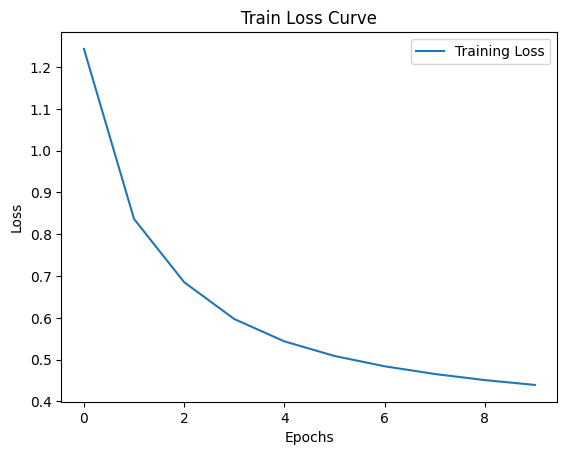

In [10]:
# Plot train loss
plt.title("Train Loss Curve")
plt.plot(all_pre_train_losses)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

## 4. Save Model & Generate Text

In [11]:
torch.save(model.state_dict(), '/content/drive/My Drive/dostoevsky-transformer.pth')

In [20]:
# Starting with new line character is a good approach
context = torch.zeros((1, 1), dtype=torch.long, device=device)

# Get and save model's predicted next NUM_GENERATE characters in Netochka Nezvanova
NUM_GENERATE = int(1e3)
with open('/content/drive/My Drive/text-generation.txt', 'w') as f:
  f.write(decode(model.generate(context, max_new_tokens=NUM_GENERATE)[0].tolist()))


In [21]:
with open('/content/drive/My Drive/text-generation.txt', 'r') as f:
  print(f.read())


 father joy, who saw in uncertain with his simplistence, hor was that my father was an of real age, that he was broke from its overwhelmed to decorated joy at beyond of the father and most provincess call. I started with impatience. I wanted to beter. for me we met agains? While with what you are you turning us? Madame Leotard have suspid, why she always taught on her every done to know how of her, drop, dark and even going hartly, abserved it me frimove in such lebracter, shamelessly swered into me. Now I was crying about — the little I was ill describated Falstaff. I fell that I was like of God’s dather. It was always such all Fade bad me to do. She was chanking her child, I thought. And in the same smile was uncantast in his formly. At last the night the pavement ome put the pavement jed.

Madame Leotard was stopped — burst‘e would the night in to kissed my fathestic Alexandra Mialovna, and inwardly awked to sleep, the procounceding of blushing at me, then an young agonising amazem

As you can see, the text is not quite completely flawless English, but it does seem that our Transformer GPT learned Dostoevsky's writing style pretty well given the size of the model.

Please refer to README.md or the header of this notebook on methods you can do to make the text more:
- accurately reflect Dostoevsky's writing style,
- grammatically correct,
- and even generate cool plots that serve as a candidate to the next chapters in Dostoevsky's famous unfinished novel Netochka Nezvanova

As for me, I simply do not have the computing power (need more NVIDIA GPUs 😔) nor the patience to run a more complicated model with millions ore parameters, as that would takes weeks or even months to complete.

Now, let me give my poor laptop a break...the end :)